----

## Amazon Kindle Reviews - Customer Segmentation and Collaborative Filtering Recommendation System

In [1]:
from requests import get
import json
from tqdm import tqdm
from collections import defaultdict
import pickle 
import re
import string
import pandas as pd
import numpy as np
from pymongo import MongoClient
from scipy.sparse import coo_matrix
from scipy.sparse import csc_matrix
import scipy
import os
import ast
import gensim
from itertools import combinations
from random import shuffle
import random
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from textblob import TextBlob
from textblob import Blobber
from gensim import corpora, models, similarities, matutils
from nltk.tag import pos_tag
nltk.download('universal_tagset')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import NMF
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%load_ext memory_profiler

[nltk_data] Downloading package universal_tagset to
[nltk_data]     /home/conrad/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


### Kindle Reviews - Text Loading and Cleaning

In [ ]:
json_full_path='/home/conrad/Documents/ds/metis/projects/Fletcher/reviews_Kindle_Store_5.json'
 
# Dataset provided by Image-based recommendations on styles and substitutes
# J. McAuley, C. Targett, J. Shi, A. van den Hengel
# SIGIR, 2015


In [ ]:
# Make counts for number of reviews
reviews_count = defaultdict(int)
with open(json_full_path) as f:
    for line in f:
        reviews_count[json.loads(line)['reviewerID']]+=1

In [ ]:
# Limit dataset to only look at users with between 10 and 15 reviews. 
# To limit dataset size and ensure we are not looking at paid reviewers or reviewers with too few reviews to build up a document per user
users_gt_10_15_reviews=[]
total_reviews=0
for key, value in reviews_count.items():
    if value > 10 and value <15:
        users_gt_10_15_reviews.append(key)
        total_reviews+=value
print(total_reviews)

In [ ]:
# Create data list, of reviews
data=[]
with open(json_full_path) as f:
    for line in f:
        if json.loads(line)['reviewerID'] in users_gt_10_15_reviews:
            data.append(json.loads(line))

In [ ]:
# Write out datalist to pickle file
with open("data_reviews_kindle.pkl", "wb") as f:
    pickle.dump(data, f)

In [2]:
# Load Amazon kindle review data. 
# Reviews stored in 'data_reviews_kindle'
with open("/home/conrad/Documents/ds/metis/projects/Fletcher/data_reviews_kindle.pkl", "rb") as f:
    data = pickle.load(f)

In [3]:
# Example of review data input. Asin is product number, overall is rating out of 5 stars
print('loaded ' + str(len(data)) + ' reviews - example review below')
data[0]

loaded 96130 reviews - example review below


{'asin': 'B000F83SZQ',
 'helpful': [0, 0],
 'overall': 5.0,
 'reviewText': "I enjoy vintage books and movies so I enjoyed reading this book.  The plot was unusual.  Don't think killing someone in self-defense but leaving the scene and the body without notifying the police or hitting someone in the jaw to knock them out would wash today.Still it was a good read for me.",
 'reviewTime': '05 5, 2014',
 'reviewerID': 'A1F6404F1VG29J',
 'reviewerName': 'Avidreader',
 'summary': 'Nice vintage story',
 'unixReviewTime': 1399248000}

In [4]:

# Set stopwords and add additional stopwords that occur frequently in the reviews, but provide little or no information
stopword_set = set(stopwords.words('english'))
stopword_set.update(('one', 'two', 'get', 'know', 'much', 'like', 'even', 'great', 'well', 'would', 'really',
                     'good', 'next', 'put', 'end', 'beginning', 'and', 'life', 'line', 'wait', 'didnt', 'part',
                     'lot', 'reading', 'love', 'book', 'series', 'story', 'author', 'read', 'way', 'I', 'A', 
                     'And', 'So', 'arnt', 'This', 'When', 'It', 'many', 'Many', 'so', 'cant', 'Yes', 'yes', 
                     'No', 'no', 'These', 'these'))


words = set(nltk.corpus.words.words())
clean_text_dict = {}
clean_text_dict_product = {}
ratings_dict = defaultdict(list)

# Clean review data. 1. remove non-alpha characters, make lower, tokenize, check if english (check against words)
# remove stopwords,store in dict where key is reviewer ID
for entry in tqdm(data):
    ratings_dict[entry['reviewerID']].append((entry['asin'], entry['overall']))
    clean_text = re.sub('[\']' , '', entry['reviewText'])
    clean_text = re.sub('[%s]' %re.escape(string.punctuation), ' ', clean_text.lower())
    clean_text = re.sub('\w*\d\w*', '', clean_text)
    clean_text = word_tokenize(clean_text)
    clean_text = [i for i in clean_text if i not in stopword_set and i in words]
    if entry['reviewerID'] not in clean_text_dict:
        clean_text_dict[entry['reviewerID']] = []
    clean_text_dict[entry['reviewerID']].extend([' '.join(clean_text)])

# Delete objects to free up RAM
del words
del data
del clean_text

100%|██████████| 96130/96130 [01:08<00:00, 1408.70it/s]


### Building Reviewer Corpus

In [5]:
corpus=[]
reviewerIDs=[]

# Create corpus reviews, where each entry is all of a user's reviews concatenated
for key in tqdm(clean_text_dict.keys()):
    corpus.append(' '.join(clean_text_dict[key]))
    reviewerIDs.append(key)

# Working with a subset of the data, 2000 reviewers. Remove all words that are not Nouns
for i in range(len(corpus[0:2000])):
    new_string=' '
    corpus[i]=pos_tag(word_tokenize(corpus[i]),tagset='universal')
    entry=[e[0] for e in corpus[i] if e[1] =='NOUN']
    corpus[i] = new_string.join(entry)

100%|██████████| 7843/7843 [00:00<00:00, 239535.77it/s]


### Final result from Topic Modeling Testing - NMF with Five Categories of Users

In [6]:
# Helper function to print out most frequent words, for determining topics
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '", topic_names[ix], "'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [7]:
# Create document term matrix with TFIDF for a subset of the corpus
cv_tfidf_ngram = TfidfVectorizer(ngram_range=(1, 2))
X_tfidf_ngram = cv_tfidf_ngram.fit_transform(corpus[:1000]).toarray()

In [8]:
# Run NMF with 5 components for topic modeling, run helper function to display topic content
nmf = NMF(n_components=5, init='random', random_state=42)
tfidf_nmf = nmf.fit_transform(X_tfidf_ngram)
display_topics(nmf, cv_tfidf_ngram.get_feature_names(), 8)


Topic  0
sex, hero, heroine, relationship, woman, man, time, men

Topic  1
character, plot, development, action, character development, time, science, fiction

Topic  2
romance, anyone, romance romance, romance time, anyone romance, time, suspense, mystery

Topic  3
people, time, world, something, work, case, cover, day

Topic  4
mystery, fun, page, interest, turner, page turner, recommend, seat


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.036s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.003822
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.869568
[t-SNE] Error after 1000 iterations: 0.766005


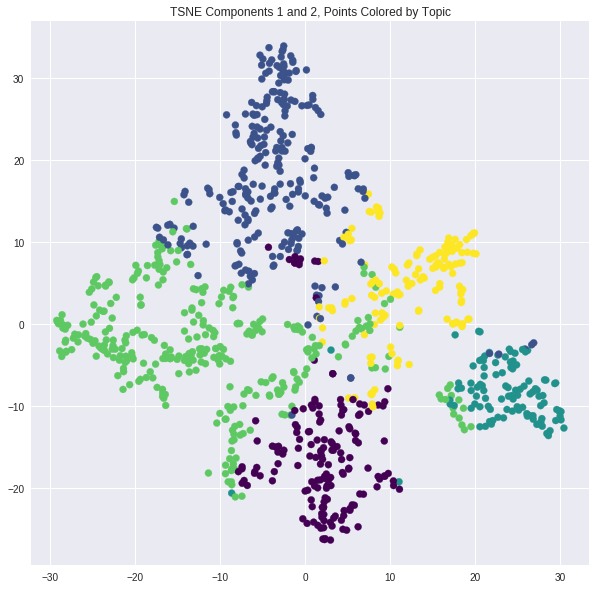

In [9]:
# Further reduce feature space using TSNE and plot output (only for visualization)
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_nmf = tsne_model.fit_transform(tfidf_nmf)
x = tsne_nmf[:,1]
y = tsne_nmf[:,0]
z = tfidf_nmf.argmax(axis=1)
df_2d_TSNE = pd.DataFrame({'x':x, 'y':y,'c':z})
plt.figure(figsize=(10,10))
plt.title('TSNE Components 1 and 2, Points Colored by Topic')
plt.scatter(x, y, c=z, cmap='viridis',label=set(z))

In [10]:
# Write out TSNE data, to be loaded into Tableau
df_2d_TSNE.to_csv('/home/conrad/Documents/ds/metis/projects/Fletcher/2d_TSNE')

### Recommendation system - Build User Item Matrix

In [11]:
# Load data for recommendaton system
json_full_path = '/home/conrad/Documents/ds/metis/projects/Fletcher/reviews_Kindle_Store_5.json'

reviews_count = defaultdict(int)

with open(json_full_path) as f:
    for line in f:
        reviews_count[json.loads(line)['reviewerID']] += 1

In [12]:
# Take a subset of the data and only take users that have a certain number of reviews per person
users_10_11_reviews = []
total_reviews = 0

for key, value in reviews_count.items():
    if value > 9 and value < 12:
        users_10_11_reviews.append(key)
        total_reviews += value
print('Total reviews loaded for recommendation ' + str(total_reviews))
    
# Create data recommendation, a list of tuples containing (userid, productID(asin), rating)
data_recommendation = []
users = []
products = []
ratings = []

with open(json_full_path) as f:
    for line in tqdm(f):
        if json.loads(line)['reviewerID'] in users_10_11_reviews:
            if json.loads(line)['overall'] >= 1.0 and json.loads(line)['overall'] <= 5.0:
                data_recommendation.append((json.loads(line)['reviewerID'], json.loads(line)['asin'], json.loads(line)['overall']))
                users.append(json.loads(line)['reviewerID'])
                products.append(json.loads(line)['asin'])
                ratings.append(json.loads(line)['overall'])
            

206it [00:00, 2057.03it/s]

Total reviews loaded for recommendation 60001


982619it [05:51, 2796.97it/s]


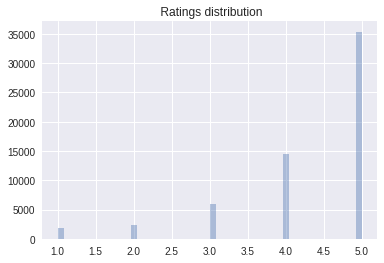

In [13]:
# Plot distribution of ratings used in recommendation system
sns.distplot(np.array(ratings),kde=False)
plt.title(' Ratings distribution')
plt.show()

In [14]:
# Create dict_product_count showing number of reviews per product. Remove any products with less than 25 reviews
dict_product_count = defaultdict(int)
data_recommendation_2 = []

for entry in data_recommendation:
    if entry[1] not in dict_product_count:
        dict_product_count[entry[1]] = 1
    else:
        dict_product_count[entry[1]] += 1
        
for entry in data_recommendation:
    if dict_product_count[entry[1]] > 5:
        data_recommendation_2.append(entry)
        
data_recommendation = data_recommendation_2
del data_recommendation_2

In [15]:
# Create dictionary to map users and products to unique indicies that will be used in sparse table
set_users = set(users)
set_products = set(products)
dict_users = {}
dict_products = {}

for i, entry in enumerate(set_users):
    dict_users[entry] = i
for j, entry in enumerate(set_products):
    dict_products[entry] = j

    
# Create arrays of indicies for users and products that correspond to a given rating
users_ind = []
products_ind = []
ratings_ind = []

for entry in data_recommendation:
    users_ind.append(dict_users[entry[0]])
    products_ind.append(dict_products[entry[1]])
    ratings_ind.append(entry[2])

# Create sparse dataframe with coo_matrix
users_ind  = np.array(users_ind)
products_ind  = np.array(products_ind)
ratings_ind = np.array(ratings_ind)
ratings_matrix = pd.DataFrame(coo_matrix((ratings_ind, (users_ind, products_ind))).toarray())

In [16]:
# Inspect sparse dataframe that will be used in recommendation system
print('#users','#products','#reviews')
print(ratings_matrix.shape, len(ratings_ind))
ratings_matrix.head()

#users #products #reviews
(5741, 29678) 12432


,0,1,2,3,4,5,6,7,8,9,...,29668,29669,29670,29671,29672,29673,29674,29675,29676,29677
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
dict_users_bkwards = {}
dict_products_bkwards = {}

for k,v in dict_users.items():
    dict_users_bkwards[v] = k
    
for k,v in dict_products.items():
    dict_products_bkwards[v] = k

### Using SVD to Reveal Latent Variables and Creating Recommendations with Collaborative Filtering

In [18]:
# Normalize ratings matrix by average of row. Fill any non-rated products with 2 star rating

ratings_matrix.replace(to_replace=0.0, value=2.0, inplace=True)
ratings_matrix = ratings_matrix.subtract(ratings_matrix.mean(axis=1),axis=0)

In [19]:
# Run SVD and assign U and VT from output
svd = TruncatedSVD(n_components=3)
svd_out = svd.fit_transform(ratings_matrix)
print('explained varience ' + str(svd.explained_variance_ratio_))
VT = svd.components_
U = svd_out

explained varience [ 0.01298796  0.00870908  0.00724385]


In [20]:
# Helper function for comparing item to item with dot products and outputing most similar items
def get_recommends(itemID, VT, num_recom=2):
    recs = []
    for item in range(VT.T.shape[0]):
        if item != itemID:
            recs.append([item,np.dot(VT.T[itemID],VT.T[item])])
    final_rec = [i[0] for i in sorted(recs, key=lambda x: x[1], reverse=True)]
    return final_rec[:num_recom]


In [21]:
# Make dictionary of best products i.e. products a user rated 4 or 5 stars where key is user
data_recommendation_high= [entry for entry in data_recommendation if entry[2] > 3]
dict_products_bkwards[j]
ratings_dict_best = defaultdict(list)

for entry in data_recommendation_high:
    ratings_dict_best[entry[0]].append(entry[1:])

In [22]:
# Creates recommendations by userID using SVD latent feature extraction
recommendation_dict_svd = defaultdict(list)
user_liked_product = []

# Find random product a user liked. Then use get_recommends helper function to find 6 other similar products
for i in range(len(dict_users_bkwards)):
    try:
        user_liked_product.append(dict_products[random.choice(ratings_dict_best[dict_users_bkwards[i]])[0]])
    except:
        continue
    recommended_products = get_recommends(user_liked_product[-1], VT, num_recom=6)
    for j in recommended_products:
        recommendation_dict_svd[dict_users_bkwards[i]].append(dict_products_bkwards[j])


In [23]:
rand_user = random.choice(list(recommendation_dict_svd.keys()))
print('For this random user ID, ' + rand_user + ' the following products from the kindle store are recommended')
recommendation_dict_svd[rand_user]

For this random user ID, A31FNFK4UPNHDP the following products from the kindle store are recommended


['B00JDYC5OI',
 'B00KF0URBM',
 'B00EPZUSYY',
 'B00HYQJPC2',
 'B00KFUJX58',
 'B00KPIPQJ2']